# Fashion Image Classification

- URL Deployment : [Heroku](https://fashion-p2m2-yoga.herokuapp.com/)


## i. Perkenalan

- Nama    : Anugrah Yoga Pratama
- Dataset : [Fashion Images](https://www.kaggle.com/datasets/vikashrajluhaniwal/fashion-images)

## ii. Import Libraries

Import pustaka.

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Flatten, BatchNormalization

import warnings
warnings.filterwarnings('ignore')

## iii. Data Loading

NB: Notebook ini dijalankan melalui google colab

### Folder Organizing

Menghubungkan google drive ke google colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Berpindah direktori ke `MyDrive`.

In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


Membuat folder `H8_p2ml2` untuk projek ini.

In [ ]:
!mkdir H8_p2ml2

Mengonfigurasi direktori kaggle untuk menghubungkan api token kaggle.json.

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/H8_p2ml2'

Berpindah ke direktori `H8_p2ml2`.

In [ ]:
%cd /content/drive/MyDrive/H8_p2ml2

/content/drive/MyDrive/H8_p2ml2


Download dataset langsung dari kaggle dan disimpan ke direktori sekarang.

In [ ]:
!kaggle datasets download -d vikashrajluhaniwal/fashion-images 

100% 334M/335M [00:02<00:00, 153MB/s]
100% 335M/335M [00:02<00:00, 147MB/s]


Ekstrak file zip yang telah didownload dan disimpan dengan folder bernama `images_dataset`.

In [ ]:
!unzip -q /content/fashion-images.zip -d images_dataset #images adalah nama folder

Memindahkan folder Apparel dan Footwear ke luar folder tersebut.

In [ ]:
# Move Apparel and Footwear folder to outer directory
!mv 'images_dataset/data/Apparel' 'images_dataset'
!mv 'images_dataset/data/Footwear' 'images_dataset'

Membuat sub-folder Men dan Women untuk menggantikan nama Boys and Girls yang ada di dalam folder Apparel.

In [ ]:
!mkdir 'images_dataset/Apparel/Men'
!mkdir 'images_dataset/Apparel/Women' 

Memindahkan semua gambar ke dalam sub-folder Men dan Women.

In [ ]:
# Move image to apparel folder
!mv images_dataset/Apparel/Boys/Images/images_with_product_ids/* 'images_dataset/Apparel/Men'
!mv images_dataset/Apparel/Girls/Images/images_with_product_ids/* 'images_dataset/Apparel/Women'

# Move image to footwear folder
!mv images_dataset/Footwear/Men/Images/images_with_product_ids/* 'images_dataset/Footwear/Men'
!mv images_dataset/Footwear/Women/Images/images_with_product_ids/* 'images_dataset/Footwear/Women'

Menghapus folder kosong yang tersisa.

In [ ]:
!rm -rf 'images_dataset/Apparel/Boys'
!rm -rf 'images_dataset/Apparel/Girls'
!rm -rf 'images_dataset/Footwear/Men/Images'
!rm -rf 'images_dataset/Footwear/Women/Images'

### Load Data

Membuat daftar direktori masing-masing image ke dalam list.

In [106]:
image_dir = [] # list kosong
dir = 'images_dataset/' # direktori awal data
for fashion in ('Apparel', 'Footwear'): 
    fashion_folder = os.path.join(dir, fashion) # menambahkan string direktori fashion
    for sex in ('Men', 'Women'):
        gender_folder = os.path.join(fashion_folder, sex) # menambahkan string direktori gender
        for filename in os.listdir(gender_folder):
            image_dir.append(os.path.join(gender_folder, filename)) # menambahkan direktori nama file ke list image_dir

len(image_dir)

2906

Membuat label fashion dan label gender.

In [6]:
fashion_label, gender_label = [], []
for img_dir in image_dir:
  gender_label.append(img_dir.split('/')[-2])
  fashion_label.append(img_dir.split('/')[-3])

Membuat dictionary yang terdiri dari path image, label fashion, dan label gender untuk nanti dijadikan dataframe.

In [7]:
image_dict = {
    'image_path': image_dir,
    'fashion': fashion_label,
    'gender': gender_label
}
df = pd.DataFrame(image_dict)

Acak baris dataframe.

In [8]:
df = df.sample(frac=1).reset_index(drop=True)
df

,image_path,fashion,gender
0,images_dataset/Footwear/Women/44465.jpg,Footwear,Women
1,images_dataset/Footwear/Men/44947.jpg,Footwear,Men
2,images_dataset/Footwear/Men/15313.jpg,Footwear,Men
3,images_dataset/Apparel/Women/39329.jpg,Apparel,Women
4,images_dataset/Apparel/Men/4208.jpg,Apparel,Men
...,...,...,...
2901,images_dataset/Apparel/Men/37520.jpg,Apparel,Men
2902,images_dataset/Apparel/Men/40974.jpg,Apparel,Men
2903,images_dataset/Apparel/Men/36211.jpg,Apparel,Men
2904,images_dataset/Footwear/Women/13563.jpg,Footwear,Women


Membuat fungsi visualisasi data untuk menampilkan image dengan 4 kondisi label yaitu:
- Apparel, Men
- Apparel, Women
- Footwear, Men
- Footwear, Women

In [107]:
# visualize sample images
def visualize_samples(samples1, samples2, samples3, samples4):
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(20,20))
    for i, sample in enumerate([samples1, samples2, samples3, samples4]):
      for j, sample_j in enumerate(sample):
          img = cv2.imread(sample_j)
          title = sample_j.split('/')[-3] + ', ' + sample_j.split('/')[-2]
          ax[i, j%len(sample)].set_title(title)
          ax[i, j%len(sample)].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

Membuat list 5 path image untuk masing-masing kondisi kelas.

In [108]:
apparel_men = df[(df['fashion'] == 'Apparel') & (df['gender'] == 'Men')]['image_path'].head().tolist()
apparel_women = df[(df['fashion'] == 'Apparel') & (df['gender'] == 'Women')]['image_path'].head().tolist()

footwear_men = df[(df['fashion'] == 'Footwear') & (df['gender'] == 'Men')]['image_path'].head().tolist()
footwear_women = df[(df['fashion'] == 'Footwear') & (df['gender'] == 'Women')]['image_path'].head().tolist()

Menampilkan visualisasi.

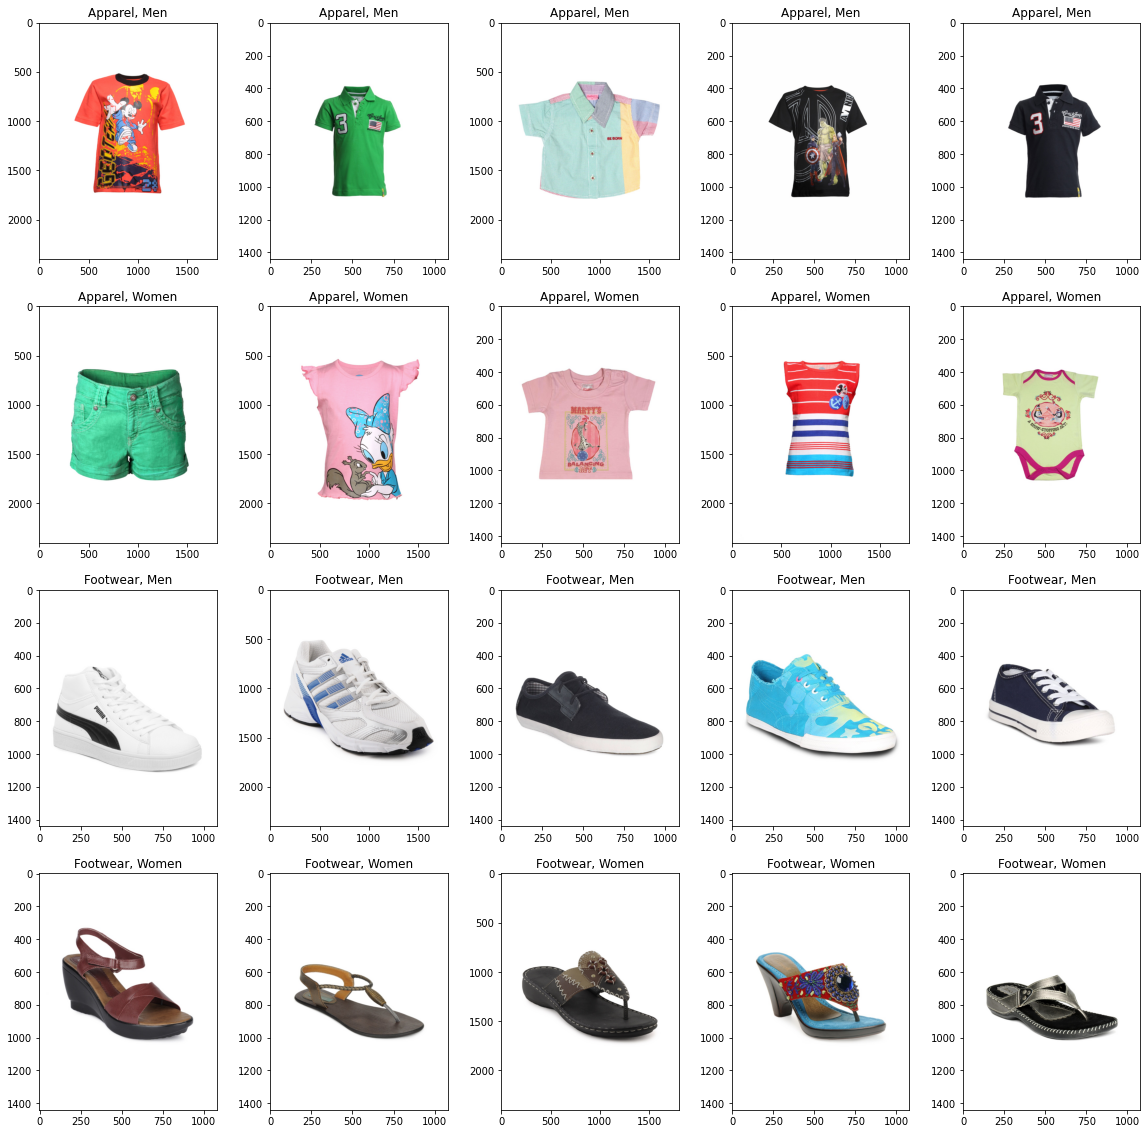

In [109]:
visualize_samples(apparel_men, apparel_women, footwear_men, footwear_women)

## iv. Exploratory Data Analysis (EDA)


Cek Jumlah Gambar

In [12]:
len(df)

2906

> Jumlah total gambar adalah 2906 gambar.

Proporsi jumlah apparel dengan footwear.

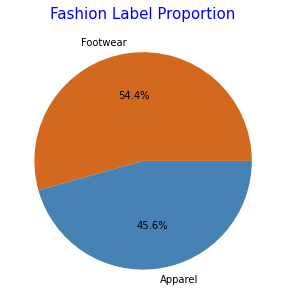

In [13]:
plt.figure(figsize=(5, 5))
count_fashion = df['fashion'].value_counts()
plt.title('Fashion Label Proportion', fontsize=15, color='blue')
plt.pie(count_fashion.values, labels=count_fashion.index, autopct='%.1f%%', colors=['chocolate', 'steelblue'])
plt.show()

> Ternyata proporsi jumlah footwear sedikit lebih besar yaitu 54.4% daripada apparel yang hanya 45.6%

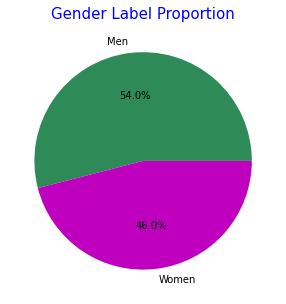

In [14]:
plt.figure(figsize=(5, 5))
count_gender = df['gender'].value_counts()
plt.title('Gender Label Proportion', fontsize=15, color='blue')
plt.pie(count_gender.values, labels=count_gender.index, autopct='%.1f%%', colors=['seagreen', 'm'])
plt.show()

> Berdasarkan pie chart di atas memperlihatkan bahwa persentase gambar fashion untuk laki-laki sedikit lebih besar yaitu 54% daripada wanita yaitu 46%.

Disini dibuat kolom baru yaitu:
- label : gabungan nama fashion dengan nama gender.
- height : jumlah piksel gambar secara vertikal.
- width : Jumlah piksrl gambar secara horizontal.
- size : ukuran total piksel gambar.

In [15]:
df['label'], df['height'], df['width'], df['size'] = 0, 0, 0, 0
df['label'] = tuple((df['fashion'])+', '+(df['gender']))
for i in range(len(df)):
  df['height'].iloc[i] = cv2.imread(df['image_path'].iloc[i]).shape[0]
  df['width'].iloc[i] = cv2.imread(df['image_path'].iloc[i]).shape[1]
df['size'] = df['width']*df['width']

In [16]:
df

,image_path,fashion,gender,label,height,width,size
0,images_dataset/Footwear/Women/44465.jpg,Footwear,Women,"Footwear, Women",1440,1080,1166400
1,images_dataset/Footwear/Men/44947.jpg,Footwear,Men,"Footwear, Men",1440,1080,1166400
2,images_dataset/Footwear/Men/15313.jpg,Footwear,Men,"Footwear, Men",2400,1800,3240000
3,images_dataset/Apparel/Women/39329.jpg,Apparel,Women,"Apparel, Women",2400,1800,3240000
4,images_dataset/Apparel/Men/4208.jpg,Apparel,Men,"Apparel, Men",2400,1800,3240000
...,...,...,...,...,...,...,...
2901,images_dataset/Apparel/Men/37520.jpg,Apparel,Men,"Apparel, Men",2400,1800,3240000
2902,images_dataset/Apparel/Men/40974.jpg,Apparel,Men,"Apparel, Men",2400,1800,3240000
2903,images_dataset/Apparel/Men/36211.jpg,Apparel,Men,"Apparel, Men",2400,1800,3240000
2904,images_dataset/Footwear/Women/13563.jpg,Footwear,Women,"Footwear, Women",2400,1800,3240000


Menampilkan jumlah gambar untuk masing-masing jumlah piksel vertikal yang tersedia berdasarkan fashion.

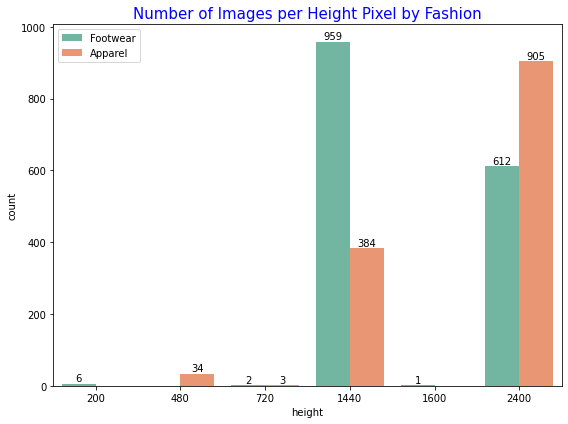

In [113]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='height', data=df, hue='fashion', palette='Set2')
plt.legend(loc='upper left')
plt.title('Number of Images per Height Pixel by Fashion', fontsize=15, color='blue')
plt.tight_layout()
for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')

> Piksel vertikal dengan jumlah gambar terbanyak untuk Apparel adalah 2400 px dan untuk Footwear adalah 1440 px.

Menampilkan jumlah gambar untuk masing-masing jumlah piksel horizontal yang tersedia berdasarkan fashion.

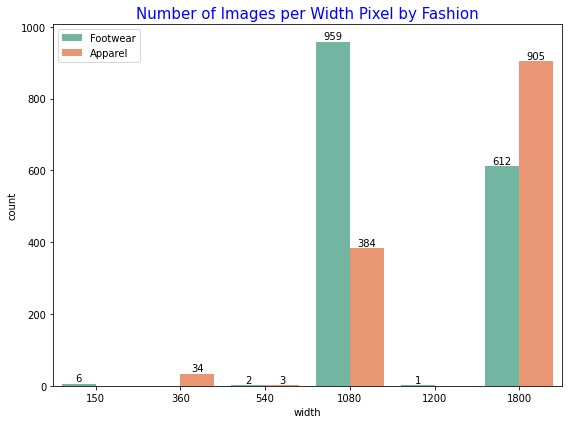

In [114]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='width', data=df, hue='fashion', palette='Set2')
plt.legend(loc='upper left')
plt.title('Number of Images per Width Pixel by Fashion', fontsize=15, color='blue')
plt.tight_layout()
for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')

> Piksel horizontal dengan jumlah gambar terbanyak untuk Apparel adalah 1800 px dan untuk Footwear adalah 1080 px.

Menampilkan jumlah gambar untuk masing-masing jumlah piksel vertikal yang tersedia berdasarkan gender.

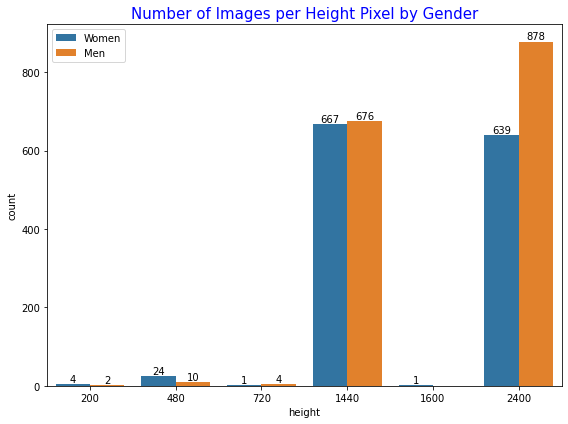

In [115]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='height', data=df, hue='gender', palette='tab10')
plt.legend(loc='upper left')
plt.title('Number of Images per Height Pixel by Gender', fontsize=15, color='blue')
plt.tight_layout()
for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')

> Piksel vertikal dengan jumlah gambar terbanyak untuk Men adalah 2400 px dan untuk Women adalah 1440 px.

Menampilkan jumlah gambar untuk masing-masing jumlah piksel horizontal yang tersedia berdasarkan gender.

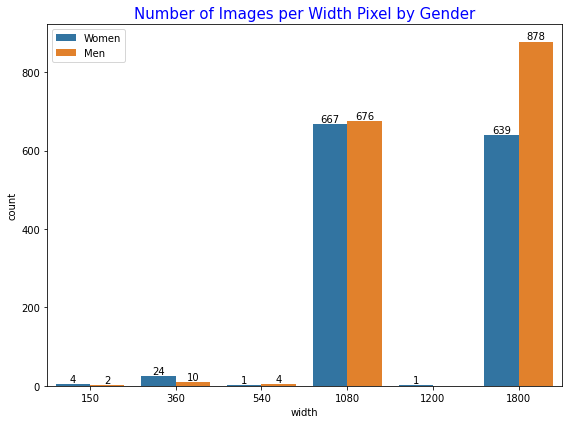

In [116]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='width', data=df, hue='gender', palette='tab10')
plt.legend(loc='upper left')
plt.title('Number of Images per Width Pixel by Gender', fontsize=15, color='blue')
plt.tight_layout()
for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')

> Piksel horizontal dengan jumlah gambar terbanyak untuk Men adalah 1800 px dan untuk Women adalah 1080 px.

Membuat list yang berisi path image dengan resolusi terkecil dan resolusi terbesar.

In [21]:
biggest5 = df[['image_path', 'size']].sort_values(by='size')['image_path'].tail().tolist()
smallest5 = df[['image_path', 'size']].sort_values(by='size')['image_path'].head().tolist()

Image dengan resolusi terbesar.

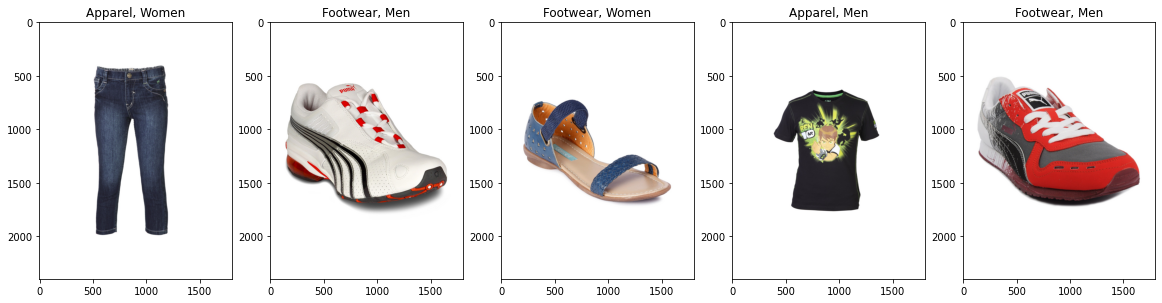

In [22]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 5))
for i, path in enumerate(biggest5):
  img = cv2.imread(path)
  title = path.split('/')[-3] + ', ' + path.split('/')[-2]
  ax[i%len(biggest5)].set_title(title)
  ax[i%len(biggest5)].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Image dengan resolusi terkecil.

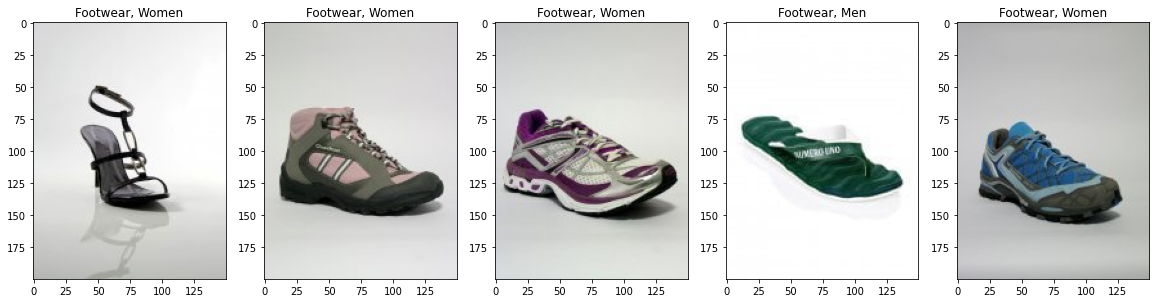

In [23]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 5))
for i, path in enumerate(smallest5):
  img = cv2.imread(path)
  title = path.split('/')[-3] + ', ' + path.split('/')[-2]
  ax[i%len(smallest5)].set_title(title)
  ax[i%len(smallest5)].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## v. Data Preprocessing


Split data dengan label berupa kolom `label` dan data berupa path image.

In [24]:
X = df['image_path']
y = df['label']
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=4)

In [25]:
X_train.shape, X_val.shape, X_test.shape

((2091,), (233,), (582,))

Definisikan parameter berupa piksel, seed, dan batch.

In [26]:
img_height= 160
img_width= 160
SEED = 1
BATCH = 64

np.random.seed(46)
tf.random.set_seed(46)

Normalisasi dan transformasi data gambar.

In [27]:
# Augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Menggabungkan dataframe antara `image_path` dengan `label`

In [28]:
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

* Pipeline augmentasi data untuk membaca gambar dari path dan mentransformasikannya.

In [29]:
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width), 
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_val = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 2091 validated image filenames belonging to 4 classes.
Found 233 validated image filenames belonging to 4 classes.
Found 582 validated image filenames belonging to 4 classes.


Cek penomoran label.

In [30]:
ds_train.class_indices

{'Apparel, Men': 0,
 'Apparel, Women': 1,
 'Footwear, Men': 2,
 'Footwear, Women': 3}

Membuat callback yaitu jika model sudah menemui titik optimalnya dan dengan model checkpoint untuk menyimpan modelnya.

In [76]:
# callbacks
callbacks = [
    EarlyStopping(monitor= 'val_loss', mode= 'min', patience=5, verbose=1),
    ModelCheckpoint('base_model_multiclass.hdf5', monitor='val_loss', save_best_only= True)
    #ReduceLROnPlateau
]

## vi. Model Definition


Mendefinisikan model awal yang dibuat, misalnya dengan arsitektur sequential sebagai berikut:
- 3 kali konvolusi 2 dimensi dengan filter masing-masing berjumlah 16, 32, 64, kernel size berukuran 3x3,
 dan activation berupa relu.
- 3 kali MaxPooling dengan ukuran 2x2 dan jarak pooling adalah 2 piksel.
- Hasil akhir konvolusi dilakukan *flatten*.
- Terdapat 2 layer pada neural network masing-masing berjumlah 256 dan 32 neuron dan activation berupa relu.
- Terdapat output yang berjumlah 4 neuron dengan activation berupa softmax.

In [77]:
input= [img_height, img_width, 3]

model = Sequential()

# Convolution (3 times filter with 3 time maxpooling)
model.add(Conv2D(filters=16,kernel_size=3, activation= 'relu', input_shape=input))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32,kernel_size=3, activation= 'relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64,kernel_size=3, activation= 'relu'))
model.add(MaxPooling2D())
model.add(Flatten())

# Masuk Neural Net (2 Hidden Layer)
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=32, activation='relu'))

model.add(Dense(units=4, activation='softmax'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 158, 158, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 79, 79, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 77, 77, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 38, 38, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 18, 18, 64)     

Model dicompile dengan parameter sebagai berikut:
- Optimizer adam
- loss categorical crossentropy
- metrics accuracy

In [78]:
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics= ['accuracy'])

## vii. Model Training


Model dilakukan traininng dengan epoch sebanyak 30 kali, menggunakan data pipeline, ukuran batch 64, dan menggunakan callback untuk pemberhentian otomatis dan menyimpan model terbaik.

In [79]:
epochs = 30
history_begin = model.fit(
    ds_train, 
    batch_size= BATCH, 
    epochs=epochs, 
    validation_data=ds_val, 
    callbacks= callbacks, 
    verbose=1
)

Epoch 1/30
33/33 [==============================] - 173s 5s/step - loss: 1.1750 - accuracy: 0.4319 - val_loss: 0.7650 - val_accuracy: 0.6824
Epoch 2/30
33/33 [==============================] - 168s 5s/step - loss: 0.8595 - accuracy: 0.6035 - val_loss: 0.7114 - val_accuracy: 0.7382
Epoch 3/30
33/33 [==============================] - 168s 5s/step - loss: 0.7635 - accuracy: 0.6389 - val_loss: 0.5983 - val_accuracy: 0.6953
Epoch 4/30
33/33 [==============================] - 168s 5s/step - loss: 0.7082 - accuracy: 0.6542 - val_loss: 0.5146 - val_accuracy: 0.8069
Epoch 5/30
33/33 [==============================] - 168s 5s/step - loss: 0.6763 - accuracy: 0.6648 - val_loss: 0.5136 - val_accuracy: 0.8026
Epoch 6/30
33/33 [==============================] - 167s 5s/step - loss: 0.6547 - accuracy: 0.6848 - val_loss: 0.5587 - val_accuracy: 0.7554
Epoch 7/30
33/33 [==============================] - 166s 5s/step - loss: 0.6318 - accuracy: 0.6973 - val_loss: 0.5346 - val_accuracy: 0.7468
Epoch 8/30
33

## viii. Model Evaluation


Membuat fungsi untuk menampilkan visualisasi loss dan akurasi terhadap dua data train dan val.

In [80]:
def loss_acc(data_result):
    fig, ax = plt.subplots(ncols=2, figsize=(14, 5))
    ax[0].plot(np.arange(1, 1+len(data_result)), data_result['loss'])
    ax[0].plot(np.arange(1, 1+len(data_result)), data_result['val_loss'])
    ax[0].set_title('Loss', fontsize=16, loc='center', color='maroon')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(labels=['loss', 'val_loss'])

    ax[1].plot(np.arange(1, 1+len(data_result)), data_result['accuracy'])
    ax[1].plot(np.arange(1, 1+len(data_result)), data_result['val_accuracy'])
    ax[1].set_title('Accuracy', fontsize=16, loc='center', color='maroon')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, symbol='%'))
    ax[1].legend(labels=['accuracy', 'val_accuracy'])

    plt.tight_layout()
    plt.show()

Membuat fungsi untuk menampilkan hasil classification report yang dihitung berdasarkan hasil prediksi model dengan label `y_test` yang sebenarnya. 

In [81]:
def class_report(model):
    decode = dict((value, key) for key, value in ds_train.class_indices.items())
    y_pred = model.predict(ds_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = pd.Series(y_pred).replace(decode)
    print(classification_report(y_test, y_pred))

Menampilkan hasil visualisasi history model.

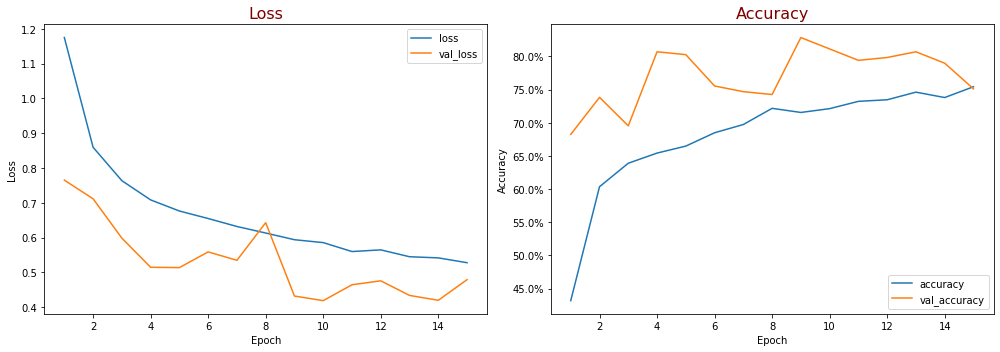

In [82]:
result = pd.DataFrame(history_begin.history) # Membuat dataframe dari histori model
loss_acc(result)

Berdasarkan grafik loss dan akurasi di atas didapatkan beberapa poin sebagai berikut:
1. Training loss semakin turun dan training akurasi semakin naik menunjukkan model semakin membaik.
2. Pada epoch ke 10, validation loss bernilai minimum dan saat epoch berikutnya cenderung tidak dapat mengalami penurunan kembali.
3. Pada epoch ke 9, validation accuracy bernilai maksimum dan saat epoch berikutnya cenderung mengalami penurunan.
4. Model terbaik yang disimpan adalah saat training epoch ke 10.

Menampilkan classification report untuk model.

In [83]:
class_report(model)

                 precision    recall  f1-score   support

   Apparel, Men       0.72      0.90      0.80       147
 Apparel, Women       0.81      0.56      0.67       117
  Footwear, Men       0.61      0.96      0.75       155
Footwear, Women       0.93      0.42      0.58       163

       accuracy                           0.71       582
      macro avg       0.77      0.71      0.70       582
   weighted avg       0.77      0.71      0.70       582



Jadi, hasil dari classification report base model adalah sebagai berikut:
1. Model di tes terhadap data test memiliki akurasi 71%, dimana artinya model dapat memprediksi benar sebanyak 71 gambar dari 100 gambar.
2. Presisi yang memiliki nilai terbesar ada di kategori Women khususnya footwear women yaitu 93%, dimana artinya dari 100 gambar yang diprediksi model menghasilkan footwear women, terdapat 93 gambar yang sebenarnya footwear women dan sisanya bukan footwear women.
3. Recall yang memiliki nilai terbesar ada di kategori Men khususnya footwear men yaitu 96%, dimana artinya dari 100 gambar yang sebenarnya adalah footwear men, terdapat 96 gambar yang diprediksi model bahwa gambarnya adalah footwear men dan sisanya bukan footwear men.

### Model Improvement

Model improvement menggunakan transfer learning berupa MobileNetV2 karena memiliki akurasi yang cukup tinggi dan waktu trainin yang cukup cepat dilihat dari laman [Keras](https://keras.io/api/applications/). Ditambahkan juga batch normalization antara base model dengan pooling.

In [84]:
# Inisialisasi MobileNetV2 sebagai base model
pretrained = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=input, include_top=False)

# Layer pretrained tidak ikut di training
for layer in pretrained.layers:
    layer.trainable = False
    
# Definisikan sequential
improve_model = Sequential()

# Menambahkan base model
improve_model.add(pretrained)
improve_model.add(BatchNormalization())
improve_model.add(MaxPooling2D())
improve_model.add(Flatten())

# Neural Net
improve_model.add(Dense(units=1024, activation='relu'))
improve_model.add(Dense(units=256, activation='relu'))
improve_model.add(Dense(units=64, activation='relu'))
improve_model.add(Dense(units=16, activation='relu'))

# Output
improve_model.add(Dense(units=4, activation='softmax'))
improve_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 batch_normalization_11 (Bat  (None, 5, 5, 1280)       5120      
 chNormalization)                                                
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 2, 2, 1280)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 5120)              0         
                                                                 
 dense_61 (Dense)            (None, 1024)              5243904   
                                                     

Dari summary di atas terlihat bahwa total parameter neural network sebesar 7.7 juta dimana 5.5 juta adalah parameter yang ditrain dan 2.2 juta adalah parameter yang tidak ikut ditrain.

Compile model.

In [85]:
improve_model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics= ['accuracy'])

Callback yang digunakan masih sama dengan patience sebesar 3.

In [86]:
# callbacks
callbacks_imp = [
    EarlyStopping(monitor= 'val_loss', mode= 'min', patience=3, verbose=1),
    ModelCheckpoint('improved_model_multiclass.hdf5', monitor='val_loss', save_best_only=True)
]

Model dilakukan training dengan epoch sebanyak 20 kali, menggunakan data pipeline, ukuran batch 64, dan menggunakan callback untuk pemberhentian otomatis dan menyimpan model terbaik.

In [87]:
epochs = 20
history_improve = improve_model.fit(
    ds_train, 
    batch_size= BATCH, 
    epochs=epochs, 
    validation_data=ds_val, 
    callbacks=callbacks_imp, 
    verbose=1
)

Epoch 1/20
33/33 [==============================] - 165s 5s/step - loss: 0.8233 - accuracy: 0.6791 - val_loss: 0.9128 - val_accuracy: 0.6137
Epoch 2/20
33/33 [==============================] - 157s 5s/step - loss: 0.5075 - accuracy: 0.7944 - val_loss: 0.4710 - val_accuracy: 0.8197
Epoch 3/20
33/33 [==============================] - 156s 5s/step - loss: 0.3492 - accuracy: 0.8470 - val_loss: 0.3723 - val_accuracy: 0.8369
Epoch 4/20
33/33 [==============================] - 155s 5s/step - loss: 0.3009 - accuracy: 0.8704 - val_loss: 0.3858 - val_accuracy: 0.8541
Epoch 5/20
33/33 [==============================] - 155s 5s/step - loss: 0.2559 - accuracy: 0.8934 - val_loss: 0.4662 - val_accuracy: 0.8069
Epoch 6/20
33/33 [==============================] - 155s 5s/step - loss: 0.2519 - accuracy: 0.8967 - val_loss: 0.4142 - val_accuracy: 0.8283
Epoch 6: early stopping


Menampilkan visualisasi histori improvement.

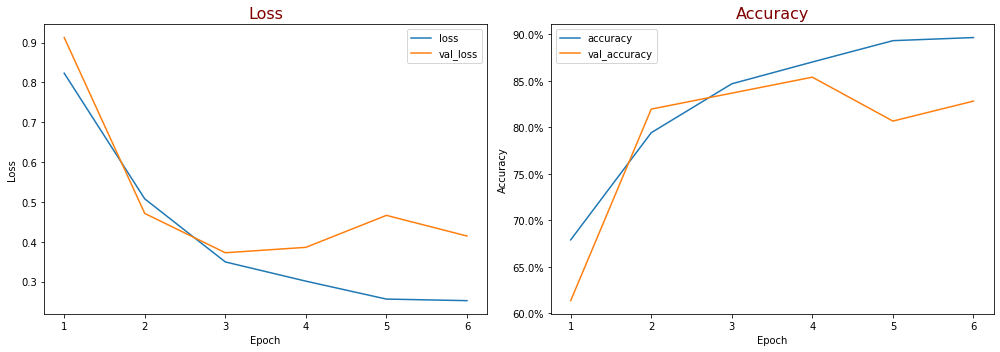

In [88]:
result_improve = pd.DataFrame(history_improve.history)
loss_acc(result_improve)

Berdasarkan grafik loss dan akurasi di atas didapatkan beberapa poin sebagai berikut:
1. Training loss semakin turun dan training akurasi semakin naik menunjukkan model semakin membaik.
2. Pada epoch ke 3, validation loss bernilai minimum dan saat epoch berikutnya cenderung tidak dapat mengalami penurunan kembali.
3. Pada epoch ke 4, validation accuracy bernilai maksimum dan saat epoch berikutnya cenderung mengalami penurunan.
4. Model terbaik yang disimpan adalah saat training epoch ke 3.

Melihat classification report dari model improvement.

In [89]:
class_report(improve_model)

                 precision    recall  f1-score   support

   Apparel, Men       0.96      0.89      0.93       147
 Apparel, Women       0.87      0.95      0.91       117
  Footwear, Men       0.89      0.75      0.82       155
Footwear, Women       0.80      0.91      0.85       163

       accuracy                           0.87       582
      macro avg       0.88      0.88      0.88       582
   weighted avg       0.88      0.87      0.87       582



Jadi, hasil dari classification report base model adalah sebagai berikut:
1. Model improvement di tes terhadap data test memiliki akurasi 87%, dimana artinya model dapat memprediksi benar sebanyak 87 gambar dari 100 gambar.
2. Presisi yang memiliki nilai terbesar ada di apparel men yaitu 96%, dimana artinya dari 100 gambar yang diprediksi model menghasilkan apparel men, terdapat 96 gambar yang sebenarnya apparel men, dan sisanya bukan apparel men.
3. Recall yang memiliki nilai terbesar ada di apparel women yaitu 95%, dimana artinya dari 100 gambar yang sebenarnya adalah apparel women, terdapat 95 gambar yang diprediksi model bahwa gambarnya adalah apparel women dan sisanya bukan apparel women.

## ix. Model Saving


Model telah disimpan berdasarkan nilai terbaik menggunakan model checkpoint yang ada di callback dan model yang disimpan adalah model improvement.

## x. Model Inference


In [90]:
filename = sorted(os.listdir('inference/'))
filename = [name for name in filename if 'image' in name]
filename

['image0.jpg',
 'image1.jpg',
 'image2.jpg',
 'image3.jpg',
 'image4.jpg',
 'image5.jpg',
 'image6.jpg',
 'image7.jpg',
 'image8.jpg',
 'image9.jpg']

In [91]:
inference_path = {'image_path': ['inference/' + edge for edge in filename],
                  'label': ['no_label']*len(filename)}

inf_df = pd.DataFrame(inference_path)
inf_df

,image_path,label
0,inference/image0.jpg,no_label
1,inference/image1.jpg,no_label
2,inference/image2.jpg,no_label
3,inference/image3.jpg,no_label
4,inference/image4.jpg,no_label
5,inference/image5.jpg,no_label
6,inference/image6.jpg,no_label
7,inference/image7.jpg,no_label
8,inference/image8.jpg,no_label
9,inference/image9.jpg,no_label


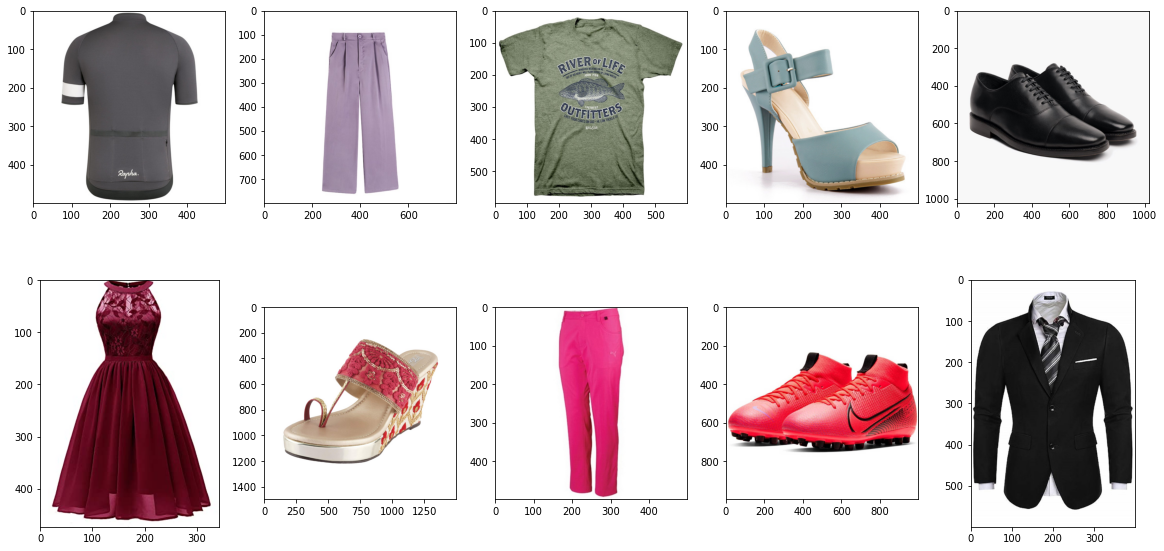

In [92]:
nrows = (len(filename) + 5 - 1)//5
plt.figure(figsize=(20, 5*nrows))
# for i in range(nrows):
for j, path in enumerate(inf_df['image_path']):
  plt.subplot(nrows, 5, j+1)
  img = cv2.imread(path)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [93]:
ds_inf = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=inf_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 10 validated image filenames belonging to 1 classes.


Load model.

In [94]:
best_model = load_model('improved_model_multiclass.hdf5')

In [95]:
decode = dict((value, key) for key, value in ds_train.class_indices.items())
y_pred_inf = best_model.predict(ds_inf)
y_pred_inf = np.argmax(y_pred_inf, axis=1)
y_pred_inf = pd.Series(y_pred_inf).replace(decode)
y_pred_inf

0       Apparel, Men
1       Apparel, Men
2     Apparel, Women
3    Footwear, Women
4      Footwear, Men
5     Apparel, Women
6    Footwear, Women
7     Apparel, Women
8      Footwear, Men
9       Apparel, Men
dtype: object

## xi. Pengambilan Kesimpulan

1. Dataset yang digunakan adalah gambar image dari [kaggle](https://www.kaggle.com/datasets/vikashrajluhaniwal/fashion-images).
2. Dataset yang digunakan terdiri dari:
    - Apparel (1326 gambar)    : Men (759 gambar) dan Women (567 gambar)
    - Footwear (1580 gambar)   : Men (811 gambar) dan Women (769 gambar)
3. Dataset dibagi menjadi 3 bagian yaitu: 
    - Trainset  : 2091 gambar
    - Valset    : 233 gambar
    - Testset   : 582 gambar
4. Image height dan width yang digunakan adalah 160x160 dengan batch 64.
5. Kelas dibagi menjadi 4 bagian yaitu:
    - Apparel Men
    - Apparel Women
    - Footwear Men
    - Footwear Women
6. Base model mendapatkan akurasi sebesar 71% dengan arsitektur sebagai berikut:
    - 3 kali konvolusi 2 dimensi dengan filter masing-masing berjumlah 16, 32, 64, kernel size berukuran 3x3, dan setiap activationnya berupa relu.
    - 3 kali MaxPooling dengan ukuran 2x2 dan jarak pooling adalah 2 piksel.
    - Hasil akhir konvolusi dilakukan *flatten*.
    - Terdapat 2 layer pada neural network masing-masing berjumlah 256 dan 32 neuron dan activation berupa relu.
    - Terdapat output yang berjumlah 4 neuron dengan activation berupa softmax.
    - Model dicompile dengan optimizer adam, loss categorical crossentropy, dan metricsnya akurasi.
7. Improvement model mendapatkan akurasi sebesar 87% dengan arsitektur sebagai berikut:
    - Menggunakan pretrained model imagenet berupa MobileNetV2 dengan layer pretrained tidak ikut ditraining.
    - 1 kali Batch normalization
    - 1 kali MaxPooling dengan ukuran 2x2 dan jarak pooling adalah 2 piksel.
    - Hasil akhir konvolusi dilakukan *flatten*.
    - Terdapat 4 layer pada neural network masing-masing berjumlah 1024, 256, 64, dan 16 neuron dan activation berupa relu.
    - Terdapat output yang berjumlah 4 neuron dengan activation berupa softmax.
    - Model dicompile dengan optimizer adam, loss categorical crossentropy, dan metricsnya akurasi.
    
8. Model terbaik yang didapatkan adalah model improvement dengan menggunakan MobileNetV2 dan didapatkan akurasi sebesar 87%.